<a href="https://colab.research.google.com/github/MuskanJ30/Flower_Recognition/blob/master/flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 68 kB 1.3 MB/s 


**Download the dataset (using lib opendatasets)**

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [ ]:
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muskanjha30
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:06<00:00, 37.1MB/s]


In [ ]:
data_dir = './flowers-recognition'

In [ ]:
import os

In [ ]:
os.listdir(data_dir)

['flowers']

In [ ]:
data_dir_main = './flowers-recognition/flowers'

In [ ]:
os.listdir(data_dir_main)

['daisy', 'tulip', 'dandelion', 'sunflower', 'rose']

In [ ]:
import shutil

In [ ]:
import torch


In [ ]:
import torchvision

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
data = ImageFolder(data_dir_main)

In [ ]:
len(data)

4317

In [ ]:
data[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F61DF300D60>, 0)

In [ ]:
data.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

0


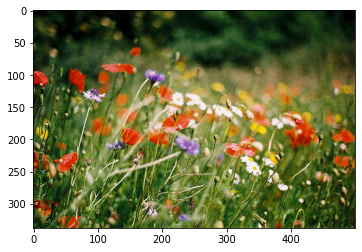

In [ ]:
img,label = data[500]
plt.imshow(img)
print(label)

In [ ]:
import torchvision.transforms as tt

In [ ]:
data  = ImageFolder(data_dir_main,tt.Compose([tt.Resize(32),tt.RandomCrop(32),tt.ToTensor()]))

0


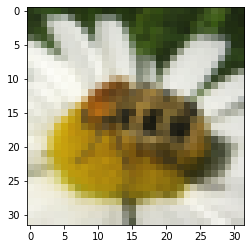

In [ ]:
img,label = data[120]
plt.imshow(img.permute(1,2,0))
print(label)

In [ ]:
from torch.utils.data import random_split

In [ ]:
val_pct = .1
val_size = int(val_pct* len(data))
train_size = len(data) - val_size

In [ ]:
val_size,train_size

(431, 3886)

In [ ]:
train_ds,val_ds = random_split(data,[train_size,val_size])

**Create Dataloaders**

In [ ]:
batch_size=50

In [ ]:
from torch.utils.data.dataloader import DataLoader

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(60, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break

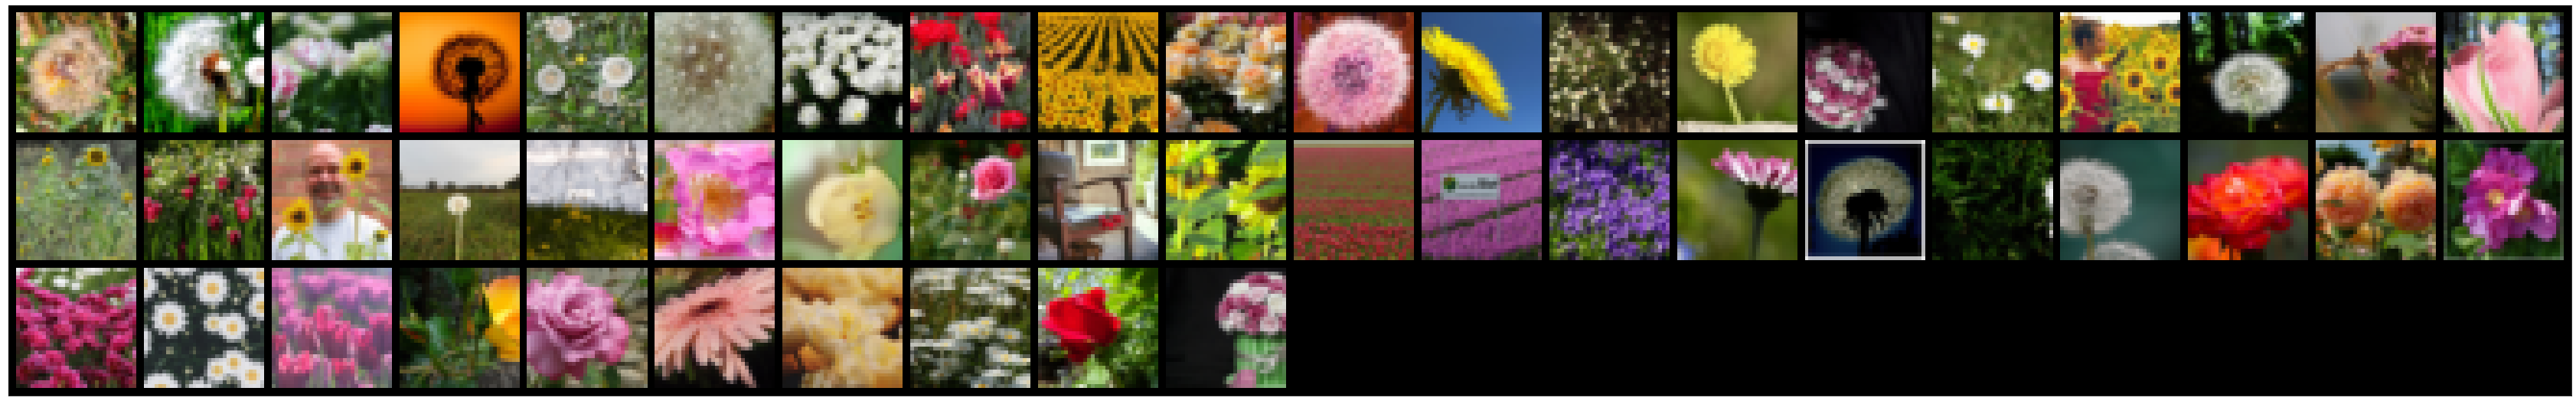

In [ ]:
show_batch(train_dl)

**GPU Utilities**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img,label = data[0]

In [ ]:
img.shape

torch.Size([3, 32, 32])

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)

In [ ]:
val_dl = DeviceDataLoader(val_dl,device)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

**Model training Utilities**

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

**Model building (either from scratch or pre trained )**

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [ ]:
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
torch.cuda.empty_cache()
model = to_device(ResNet9(3, len(data.classes)), device) ## 3 ---no of input channels rgb
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
?nn.BatchNorm2d

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [ ]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

**Pass one batch of input tenosr through Model**

In [ ]:
for batch in train_dl:
  images,label = batch
  preds = model(images)
  print(preds)
  break

tensor([[ 1.2793e-01,  2.0272e+00,  1.9900e-01,  3.3547e-01, -2.3180e+00],
        [-2.5538e+00,  1.8149e+00, -6.0199e-01, -9.2306e-01, -2.8301e+00],
        [-3.2438e-01,  1.5315e+00,  6.1112e-01, -3.7777e-01, -2.9228e+00],
        [ 5.2676e-01,  4.1255e+00, -6.7032e-01,  6.7573e-01, -3.8255e+00],
        [-6.3578e-01,  1.0349e+00, -4.1677e-01, -2.0272e+00, -3.8799e+00],
        [ 2.1283e-01,  4.6105e+00,  1.1302e+00, -3.3162e-03, -1.9193e+00],
        [-1.5111e-01,  1.1885e+00,  1.1527e+00,  2.9887e-01, -3.8569e+00],
        [-1.5081e-01,  4.3677e+00,  6.6369e-01,  7.1952e-01, -3.5758e+00],
        [ 3.7015e-01,  1.0240e+00, -1.2766e+00, -1.0373e+00, -2.9642e+00],
        [-4.2491e-01,  1.9147e+00,  1.5102e+00, -2.1800e+00, -4.2683e+00],
        [ 7.0571e-02,  1.6195e+00,  5.0912e-02,  1.7424e+00, -2.5860e+00],
        [-1.5237e+00,  5.7557e+00, -1.5666e+00, -7.8224e-01, -6.0300e+00],
        [ 2.9184e-01,  3.0746e+00,  1.1838e+00,  4.2517e-01, -3.3972e+00],
        [-3.1197e-01,  2.

**Training**

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.610403060913086, 'val_acc': 0.2058064490556717}]

In [ ]:
history += fit(5,.1,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 5.3609, val_loss: 1.6402, val_acc: 0.2272
Epoch [1], train_loss: 1.6323, val_loss: 1.5999, val_acc: 0.2132
Epoch [2], train_loss: 1.6057, val_loss: 1.6136, val_acc: 0.2167
Epoch [3], train_loss: 1.6061, val_loss: 1.5941, val_acc: 0.2785
Epoch [4], train_loss: 1.6130, val_loss: 1.5842, val_acc: 0.2327


In [ ]:
history += fit(3,.05,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.5723, val_loss: 1.4842, val_acc: 0.3374
Epoch [1], train_loss: 1.4155, val_loss: 1.4143, val_acc: 0.4194
Epoch [2], train_loss: 1.2912, val_loss: 1.2024, val_acc: 0.5057


In [ ]:
history += fit(3,.01,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.2073, val_loss: 1.1160, val_acc: 0.5337
Epoch [1], train_loss: 1.1794, val_loss: 1.0855, val_acc: 0.5268
Epoch [2], train_loss: 1.1436, val_loss: 1.0946, val_acc: 0.6155


In [ ]:
history += fit(3,.01,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.1311, val_loss: 1.0634, val_acc: 0.6155
Epoch [1], train_loss: 1.1250, val_loss: 1.0624, val_acc: 0.6459
Epoch [2], train_loss: 1.0981, val_loss: 1.0645, val_acc: 0.6199


In [ ]:
history += fit(5,.008,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.0756, val_loss: 1.0157, val_acc: 0.6355
Epoch [1], train_loss: 1.0820, val_loss: 0.9820, val_acc: 0.6415
Epoch [2], train_loss: 1.0518, val_loss: 1.0010, val_acc: 0.6475
Epoch [3], train_loss: 1.0287, val_loss: 0.9615, val_acc: 0.6384
Epoch [4], train_loss: 1.0108, val_loss: 0.9257, val_acc: 0.6679


In [ ]:
history += fit(3,.005,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.9853, val_loss: 0.8937, val_acc: 0.6784
Epoch [1], train_loss: 0.9795, val_loss: 0.9238, val_acc: 0.6844
Epoch [2], train_loss: 0.9582, val_loss: 0.8915, val_acc: 0.6839


In [ ]:
history += fit(3,.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.9437, val_loss: 0.8842, val_acc: 0.6824
Epoch [1], train_loss: 0.9123, val_loss: 0.8678, val_acc: 0.6993
Epoch [2], train_loss: 0.9312, val_loss: 0.8815, val_acc: 0.6908


In [ ]:
history += fit(3,.0005,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.9244, val_loss: 0.8721, val_acc: 0.6964
Epoch [1], train_loss: 0.9168, val_loss: 0.8630, val_acc: 0.6928
Epoch [2], train_loss: 0.9149, val_loss: 0.8555, val_acc: 0.7044


In [ ]:
history += fit(3,.0005,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.9073, val_loss: 0.8710, val_acc: 0.6948
Epoch [1], train_loss: 0.9187, val_loss: 0.8721, val_acc: 0.6739
Epoch [2], train_loss: 0.8998, val_loss: 0.8660, val_acc: 0.7048


In [ ]:
history += fit(3,.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.9113, val_loss: 0.8561, val_acc: 0.6859
Epoch [1], train_loss: 0.8998, val_loss: 0.8519, val_acc: 0.6928
Epoch [2], train_loss: 0.8962, val_loss: 0.8621, val_acc: 0.6859


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

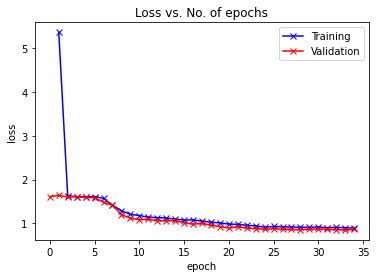

In [ ]:
plot_losses(history)

In [ ]:
history += fit(4,.0001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.8985, val_loss: 0.8573, val_acc: 0.6939
Epoch [1], train_loss: 0.8903, val_loss: 0.8455, val_acc: 0.6824
Epoch [2], train_loss: 0.8904, val_loss: 0.8677, val_acc: 0.6948
Epoch [3], train_loss: 0.8799, val_loss: 0.8533, val_acc: 0.6928


In [ ]:
history += fit(3,.0001,model,train_dl,val_dl,)

Epoch [0], train_loss: 0.8815, val_loss: 0.8586, val_acc: 0.6948
Epoch [1], train_loss: 0.8864, val_loss: 0.8515, val_acc: 0.6988
Epoch [2], train_loss: 0.9051, val_loss: 0.8386, val_acc: 0.7024


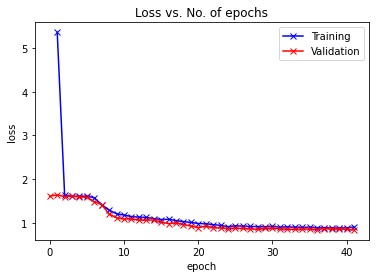

In [ ]:
plot_losses(history)

In [ ]:
import jovian

In [ ]:
jovian.commit(project ='first project ')

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


**Testing with individual images**

In [ ]:
def predict_image(img, model,classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
img,label = val_ds[0]
predict_image(img,model,data.classes)

'sunflower'

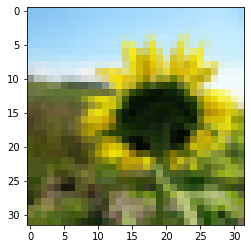

In [ ]:
plt.imshow(img.permute(1,2,0))

In [ ]:
def show_imagegpred(img,label) :
  predicted = predict_image(img,model,data.classes)
  print('original label:',data.classes[label])
  print('predicted:', predicted)
  plt.imshow(img.permute(1,2,0))

original label: daisy
predicted: daisy


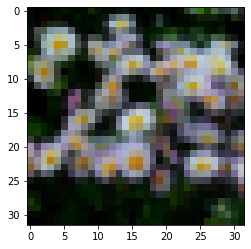

In [ ]:
img,label = val_ds[50]
show_imagegpred(img,label)

original label: tulip
predicted: tulip


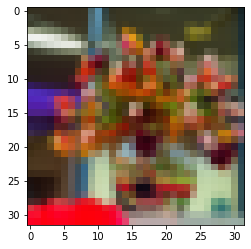

In [ ]:
show_imagegpred(*val_ds[16])

original label: rose
predicted: rose


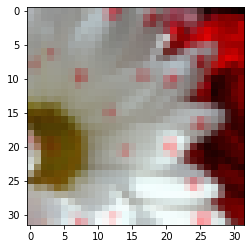

In [ ]:
show_imagegpred(*val_ds[6])

**Transfer Learning**

In [ ]:
from torchvision import models

class Resnet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(Resnet34(len(data.classes),pretrained = True),device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
data  = ImageFolder(data_dir_main,tt.Compose([tt.Resize(img_size),tt.RandomCrop(img_size),tt.ToTensor(),tt.Normalize(*imagenet_stats)]))
train_ds,val_ds = random_split(data,[train_size,val_size])
batch_size = 50
from torch.utils.data.dataloader import DataLoader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
print(device)
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

cuda


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
history = evaluate(model,val_dl)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
history

{'val_loss': 1.74142587184906, 'val_acc': 0.18316128849983215}

In [ ]:
history += fit_one_cycle(5,0.001,model,train_dl,val_dl,weight_decay = 0.01,grad_clip = 0.1,opt_func = torch.optim.Adam)

  0%|          | 0/78 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], train_loss: 0.3620, val_loss: 2.3561, val_acc: 0.5930


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.7310, val_loss: 1.0494, val_acc: 0.5670


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6400, val_loss: 0.5893, val_acc: 0.8342


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.5021, val_loss: 0.5575, val_acc: 0.8215


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3461, val_loss: 0.3516, val_acc: 0.8751


TypeError: ignored

original label: sunflower
predicted: sunflower


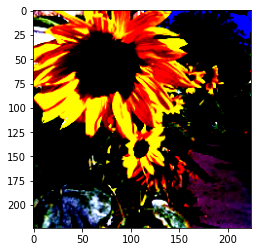

In [ ]:
img,label  = val_ds[10]
show_imagegpred(img,label)

In [ ]:
img,label = val_ds[12]

In [ ]:
data.classes[label]

'dandelion'

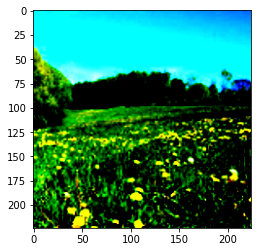

In [ ]:
plt.imshow(img.permute(1,2,0))